In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\KDEF_and_AKDEF\\KDEF', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "AF":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(4900):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[4:6] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[4:6]]

        return img, label

    def __len__(self):
        return len(self.files)

Load Data
---------


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(4900)
idx = {'val': idx[0:490], 'train': idx[490:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images


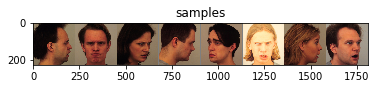

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, writer=None, i=0,  num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet_'+str(i)+'.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
accuracies = []
index = list(np.random.permutation(4900))


for i in range(10):
    idx = {'val': index[490*i:490*(i+1)], 'train': index[:i*490]+index[((i+1)*490) -1:]}

    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=16,
                                             shuffle=True)
              for x in ['train', 'val']}

    model_ft = models.densenet161(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    writer = SummaryWriter('./logs/densenet161_kfold_'+str(i))

    model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                     dataloaders, writer, i, num_epochs=20)
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 1.3234 Acc: 0.4998


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.6204 Acc: 0.7735

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.4925 Acc: 0.8243


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.3882 Acc: 0.8714

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2867 Acc: 0.9059


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.2542 Acc: 0.9143

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1828 Acc: 0.9381


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.2287 Acc: 0.9245

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1417 Acc: 0.9560


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1784 Acc: 0.9388

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0918 Acc: 0.9732


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.2005 Acc: 0.9224

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0612 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1516 Acc: 0.9388

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0482 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.32it/s]


val Loss: 0.1490 Acc: 0.9490

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0456 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.1454 Acc: 0.9469

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0445 Acc: 0.9887


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1463 Acc: 0.9571

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0391 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1553 Acc: 0.9490

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0410 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1433 Acc: 0.9469

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0398 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1373 Acc: 0.9592

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0343 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1383 Acc: 0.9490

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0345 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1405 Acc: 0.9510

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0316 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1390 Acc: 0.9531

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0324 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1409 Acc: 0.9490

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0363 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.33it/s]


val Loss: 0.1356 Acc: 0.9490

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0349 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1354 Acc: 0.9510

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0368 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1331 Acc: 0.9551

Training complete in 65m 28s
Best val Acc: 0.959184


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [0.9591836734693878]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 1.3679 Acc: 0.4859


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.6717 Acc: 0.7551

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.5079 Acc: 0.8279


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.3310 Acc: 0.8796

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2889 Acc: 0.9032


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.2605 Acc: 0.9102

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1913 Acc: 0.9399


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.2088 Acc: 0.9265

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1303 Acc: 0.9619


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1831 Acc: 0.9347

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1010 Acc: 0.9696


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1411 Acc: 0.9531

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0624 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0985 Acc: 0.9612

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0502 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0890 Acc: 0.9673

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0482 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0874 Acc: 0.9694

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0424 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1015 Acc: 0.9694

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0384 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0889 Acc: 0.9714

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0386 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0875 Acc: 0.9694

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0372 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.0931 Acc: 0.9694

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0339 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.0880 Acc: 0.9694

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0404 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.0898 Acc: 0.9653

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0412 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0837 Acc: 0.9714

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0366 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0948 Acc: 0.9653

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0351 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0824 Acc: 0.9694

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0316 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0825 Acc: 0.9653

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0312 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0896 Acc: 0.9673

Training complete in 65m 31s
Best val Acc: 0.971429



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 1.3592 Acc: 0.4941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.7503 Acc: 0.7265

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.4969 Acc: 0.8200


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.4032 Acc: 0.8490

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2635 Acc: 0.9147


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.2737 Acc: 0.9102

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1785 Acc: 0.9451


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.2286 Acc: 0.9184

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1354 Acc: 0.9567


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.2467 Acc: 0.9143

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1015 Acc: 0.9698


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.2557 Acc: 0.9122

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0671 Acc: 0.9841


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.1940 Acc: 0.9224

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0556 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1755 Acc: 0.9347

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0513 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1773 Acc: 0.9388

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0459 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1568 Acc: 0.9449

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0432 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1613 Acc: 0.9429

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0421 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1589 Acc: 0.9469

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0336 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1571 Acc: 0.9449

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0320 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1539 Acc: 0.9531

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0342 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1513 Acc: 0.9469

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0316 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1598 Acc: 0.9510

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0306 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1566 Acc: 0.9510

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0297 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1549 Acc: 0.9490

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0324 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1555 Acc: 0.9490

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0339 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.1563 Acc: 0.9429

Training complete in 65m 32s
Best val Acc: 0.953061



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 1.3339 Acc: 0.5075


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.5847 Acc: 0.8000

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.4732 Acc: 0.8397


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.3686 Acc: 0.8816

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2608 Acc: 0.9136


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.2326 Acc: 0.9327

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1746 Acc: 0.9449


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.2637 Acc: 0.9122

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1335 Acc: 0.9578


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.2012 Acc: 0.9429

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1087 Acc: 0.9662


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1611 Acc: 0.9633

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0557 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1338 Acc: 0.9633

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0458 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1391 Acc: 0.9673

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0467 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1278 Acc: 0.9653

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0467 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1451 Acc: 0.9653

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0369 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1247 Acc: 0.9673

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0392 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1361 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0335 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1246 Acc: 0.9653

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0324 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1164 Acc: 0.9694

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0352 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1292 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0370 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1315 Acc: 0.9653

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0297 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1178 Acc: 0.9673

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0339 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1278 Acc: 0.9653

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0340 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1175 Acc: 0.9673

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0318 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1295 Acc: 0.9673

Training complete in 65m 30s
Best val Acc: 0.969388



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 1.3375 Acc: 0.4934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.34it/s]


val Loss: 0.5171 Acc: 0.8306

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.4703 Acc: 0.8383


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.33it/s]


val Loss: 0.2903 Acc: 0.9000

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2651 Acc: 0.9132


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.32it/s]


val Loss: 0.2025 Acc: 0.9122

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1908 Acc: 0.9392


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1533 Acc: 0.9408

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1327 Acc: 0.9585


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1421 Acc: 0.9469

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0931 Acc: 0.9739


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1027 Acc: 0.9633

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0629 Acc: 0.9828


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0839 Acc: 0.9673

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0506 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.0810 Acc: 0.9653

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0430 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.31it/s]


val Loss: 0.0765 Acc: 0.9735

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0454 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0727 Acc: 0.9755

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0383 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.0730 Acc: 0.9776

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0406 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.0724 Acc: 0.9776

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0363 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.0750 Acc: 0.9714

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0357 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0730 Acc: 0.9776

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0337 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0736 Acc: 0.9735

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0358 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0726 Acc: 0.9755

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0321 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0735 Acc: 0.9776

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0357 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0763 Acc: 0.9694

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0328 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.0751 Acc: 0.9755

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0342 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.0753 Acc: 0.9755

Training complete in 65m 31s
Best val Acc: 0.977551



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409, 0.9775510204081633]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 1.3177 Acc: 0.5070


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.5807 Acc: 0.8041

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.4762 Acc: 0.8299


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.4120 Acc: 0.8408

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.2770 Acc: 0.9104


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.2013 Acc: 0.9224

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1697 Acc: 0.9472


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.2061 Acc: 0.9163

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1283 Acc: 0.9612


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1819 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1017 Acc: 0.9683


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1457 Acc: 0.9469

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0577 Acc: 0.9857


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.0987 Acc: 0.9612

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0542 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0945 Acc: 0.9653

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0454 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.0879 Acc: 0.9694

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0401 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0939 Acc: 0.9633

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0365 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0903 Acc: 0.9653

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0384 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0833 Acc: 0.9714

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0342 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0844 Acc: 0.9714

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0314 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.0786 Acc: 0.9673

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0309 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.0812 Acc: 0.9653

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0334 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0779 Acc: 0.9653

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0305 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0844 Acc: 0.9633

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0262 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.0813 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0283 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.0795 Acc: 0.9612

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0310 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.0815 Acc: 0.9673

Training complete in 65m 35s
Best val Acc: 0.971429



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409, 0.9775510204081633, 0.9714285714285715]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 1.3478 Acc: 0.5036


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.5893 Acc: 0.7959

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.4977 Acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.3410 Acc: 0.8857

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2716 Acc: 0.9145


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.2396 Acc: 0.9184

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.1882 Acc: 0.9385


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1885 Acc: 0.9408

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.1273 Acc: 0.9601


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1432 Acc: 0.9449

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0989 Acc: 0.9685


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1571 Acc: 0.9429

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0573 Acc: 0.9848


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1166 Acc: 0.9633

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0527 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1142 Acc: 0.9571

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0422 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1097 Acc: 0.9633

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0471 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1053 Acc: 0.9714

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0387 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.0987 Acc: 0.9612

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0342 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.0957 Acc: 0.9612

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0338 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.0980 Acc: 0.9612

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0322 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.0997 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0318 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.0969 Acc: 0.9633

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0367 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.0969 Acc: 0.9653

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0331 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1041 Acc: 0.9612

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0328 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.0950 Acc: 0.9612

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0330 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.0973 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0326 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1019 Acc: 0.9531

Training complete in 65m 53s
Best val Acc: 0.971429



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409, 0.9775510204081633, 0.9714285714285715, 0.9714285714285715]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 1.3286 Acc: 0.5061


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.6426 Acc: 0.7653

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.4922 Acc: 0.8302


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.2831 Acc: 0.9041

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.2772 Acc: 0.9079


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.3193 Acc: 0.8796

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.2012 Acc: 0.9315


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.3436 Acc: 0.8735

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1379 Acc: 0.9587


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.09it/s]


val Loss: 0.1667 Acc: 0.9429

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0857 Acc: 0.9732


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.1259 Acc: 0.9571

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0533 Acc: 0.9857


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1134 Acc: 0.9592

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0466 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.09it/s]


val Loss: 0.1025 Acc: 0.9633

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0442 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1001 Acc: 0.9673

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0371 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1061 Acc: 0.9694

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0399 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0903 Acc: 0.9755

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0331 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1060 Acc: 0.9694

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0373 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1011 Acc: 0.9694

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0308 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.0994 Acc: 0.9673

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0334 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1044 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0288 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1006 Acc: 0.9673

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0338 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0961 Acc: 0.9714

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0333 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1095 Acc: 0.9633

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0297 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.10it/s]


val Loss: 0.0961 Acc: 0.9694

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0299 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0982 Acc: 0.9694

Training complete in 65m 50s
Best val Acc: 0.975510



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409, 0.9775510204081633, 0.9714285714285715, 0.9714285714285715, 0.9755102040816327]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 1.3120 Acc: 0.5147


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.6233 Acc: 0.7776

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.4782 Acc: 0.8354


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.3481 Acc: 0.8878

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.2785 Acc: 0.9057


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.3138 Acc: 0.8837

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.1749 Acc: 0.9417


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.2846 Acc: 0.9020

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.1190 Acc: 0.9633


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.2285 Acc: 0.9184

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.1051 Acc: 0.9671


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1831 Acc: 0.9306

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0651 Acc: 0.9844


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.33it/s]


val Loss: 0.1558 Acc: 0.9388

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0533 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1479 Acc: 0.9449

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0533 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.35it/s]


val Loss: 0.1455 Acc: 0.9449

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0353 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.37it/s]


val Loss: 0.1420 Acc: 0.9429

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0353 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.32it/s]


val Loss: 0.1510 Acc: 0.9490

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0380 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.38it/s]


val Loss: 0.1447 Acc: 0.9531

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0345 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1362 Acc: 0.9571

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0337 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.1403 Acc: 0.9551

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0362 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.37it/s]


val Loss: 0.1403 Acc: 0.9551

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0311 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.06it/s]


val Loss: 0.1396 Acc: 0.9551

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0319 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.07it/s]


val Loss: 0.1361 Acc: 0.9551

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0338 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.11it/s]


val Loss: 0.1331 Acc: 0.9551

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0361 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.09it/s]


val Loss: 0.1373 Acc: 0.9531

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0325 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.1428 Acc: 0.9531

Training complete in 66m 14s
Best val Acc: 0.957143



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409, 0.9775510204081633, 0.9714285714285715, 0.9714285714285715, 0.9755102040816327, 0.9571428571428572]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:05<00:00,  1.48it/s]


train Loss: 1.3084 Acc: 0.5293


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:11<00:00,  2.60it/s]


val Loss: 0.7175 Acc: 0.7102

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:18<00:00,  1.39it/s]


train Loss: 0.4617 Acc: 0.8463


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.92it/s]


val Loss: 0.3964 Acc: 0.8714

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:16<00:00,  1.40it/s]


train Loss: 0.2813 Acc: 0.9011


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.05it/s]


val Loss: 0.3211 Acc: 0.8735

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:16<00:00,  1.41it/s]


train Loss: 0.1798 Acc: 0.9456


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.03it/s]


val Loss: 0.2843 Acc: 0.8939

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:15<00:00,  1.41it/s]


train Loss: 0.1270 Acc: 0.9624


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.90it/s]


val Loss: 0.1945 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:15<00:00,  1.41it/s]


train Loss: 0.0850 Acc: 0.9771


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.05it/s]


val Loss: 0.2465 Acc: 0.9184

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.0548 Acc: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.94it/s]


val Loss: 0.1969 Acc: 0.9306

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:14<00:00,  1.42it/s]


train Loss: 0.0438 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.06it/s]


val Loss: 0.1702 Acc: 0.9306

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.42it/s]


train Loss: 0.0362 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.89it/s]


val Loss: 0.1725 Acc: 0.9367

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:14<00:00,  1.42it/s]


train Loss: 0.0376 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.93it/s]


val Loss: 0.1559 Acc: 0.9367

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.0384 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.96it/s]


val Loss: 0.1656 Acc: 0.9388

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:14<00:00,  1.42it/s]


train Loss: 0.0326 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.97it/s]


val Loss: 0.1789 Acc: 0.9306

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.42it/s]


train Loss: 0.0348 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.91it/s]


val Loss: 0.1639 Acc: 0.9388

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:14<00:00,  1.42it/s]


train Loss: 0.0353 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.01it/s]


val Loss: 0.1591 Acc: 0.9388

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.0299 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.98it/s]


val Loss: 0.1504 Acc: 0.9449

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:20<00:00,  1.37it/s]


train Loss: 0.0304 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.94it/s]


val Loss: 0.1523 Acc: 0.9347

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:18<00:00,  1.39it/s]


train Loss: 0.0316 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.93it/s]


val Loss: 0.1583 Acc: 0.9306

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0314 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.1547 Acc: 0.9367

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:05<00:00,  1.48it/s]


train Loss: 0.0300 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1554 Acc: 0.9388

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0289 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1468 Acc: 0.9449

Training complete in 68m 8s
Best val Acc: 0.944898



------------------------------------
 Accuracies  [0.9591836734693878, 0.9714285714285715, 0.953061224489796, 0.9693877551020409, 0.9775510204081633, 0.9714285714285715, 0.9714285714285715, 0.9755102040816327, 0.9571428571428572, 0.9448979591836736]





# Load and test the model

In [8]:
model_ft.load_state_dict(torch.load('saved/densenet.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

FileNotFoundError: [Errno 2] No such file or directory: 'saved/densenet.pt'

In [ ]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)